<a href="https://colab.research.google.com/github/kskaran94/Sepsis_Identification/blob/master/EDA_Temporal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries Used

In [0]:
import pandas as pd
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pylab import rcParams

In [3]:
uploaded = files.upload()

Saving train_patient.csv.zip to train_patient.csv.zip


## Unzip files

In [4]:
!unzip train_patient.csv.zip

Archive:  train_patient.csv.zip
  inflating: train_patient.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._train_patient.csv  


## Data Exploration and Cleaning

In [5]:
train = pd.read_csv('train_patient.csv')
train.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_id,time
0,93.0,100.0,34.50,93.0,70.0,57.0,14.5,NaN,0.0,21.0,1.0,7.51,25.0,NaN,NaN,12.0,NaN,NaN,107.0,NaN,NaN,122.0,NaN,NaN,NaN,4.3,NaN,NaN,30.1,10.7,NaN,13.1,NaN,NaN,82.6,0,0.0,1.0,-86.86,2,0,0,0
1,90.5,100.0,34.75,112.0,80.0,59.5,16.0,NaN,0.0,NaN,0.5,7.53,23.0,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.6,0,0.0,1.0,-86.86,3,0,0,1
2,90.0,100.0,35.45,115.0,76.5,58.5,18.5,NaN,0.0,NaN,NaN,7.49,35.0,98.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.6,0,0.0,1.0,-86.86,4,0,0,2
3,86.0,100.0,35.30,88.5,59.0,47.0,23.0,NaN,0.0,NaN,0.5,7.44,NaN,98.0,NaN,NaN,NaN,NaN,107.0,NaN,NaN,NaN,NaN,2.1,NaN,3.8,NaN,NaN,21.1,NaN,NaN,NaN,NaN,NaN,82.6,0,0.0,1.0,-86.86,5,0,0,3
4,90.0,100.0,35.20,92.0,62.0,48.0,18.0,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,NaN,NaN,NaN,2.1,NaN,3.8,NaN,NaN,21.1,NaN,NaN,NaN,NaN,NaN,82.6,0,0.0,1.0,-86.86,6,0,0,4


### Select relevant Columns

In [6]:
filter_cols = ['Patient_id', 'time', 'HR', 'Age', 'MAP', 'Resp', 'Temp', 'WBC', 
               'PaCO2', 'SepsisLabel']

filter_train = train[filter_cols]
filter_train.head()

,Patient_id,time,HR,Age,MAP,Resp,Temp,WBC,PaCO2,SepsisLabel
0,0,0,93.0,82.6,70.0,14.5,34.50,13.1,25.0,0
1,0,1,90.5,82.6,80.0,16.0,34.75,NaN,23.0,0
2,0,2,90.0,82.6,76.5,18.5,35.45,NaN,35.0,0
3,0,3,86.0,82.6,59.0,23.0,35.30,NaN,NaN,0
4,0,4,90.0,82.6,62.0,18.0,35.20,NaN,NaN,0


### Total Number of Patients

In [7]:
len(filter_train['Patient_id'].unique())

30336

### Total Number of patients with Sepsis


In [8]:
grp_sepsis_rep = np.array(filter_train.groupby(['Patient_id']) \
                          ['SepsisLabel'].sum())

len(grp_sepsis_rep[grp_sepsis_rep > 0])

2377

### Number of hours a patient spends in Hospital

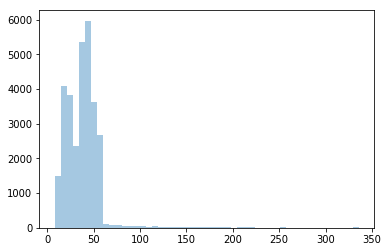

In [9]:
agg_patient_time = np.array(filter_train.groupby(['Patient_id'])['SepsisLabel']\
                            .count())

sns.distplot(agg_patient_time, kde=False);

We can remove those patients with more than 60 hours in the hospital. These patients (more than 60 hours in hospital) are considered outliers . The reason behind this is that we will be using LSTM for modeling and window of size 350 won't be a great idea. 

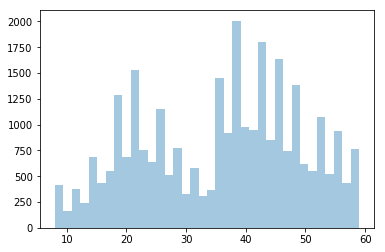

In [10]:
agg_patient_time = np.array(filter_train.groupby(['Patient_id'])['SepsisLabel']\
                            .count())

agg_patient_time = agg_patient_time[agg_patient_time < 60]

sns.distplot(agg_patient_time, kde=False);

### Remove patients with >60 hours of data

In [0]:
temp = filter_train.groupby(['Patient_id'])['SepsisLabel'].count().reset_index()


sel_pid = np.array(temp[temp['SepsisLabel'] <=60]['Patient_id'])


patient_filter_train = filter_train[filter_train['Patient_id'].isin(sel_pid)]

### Total Number of Patients after filtering patients with > 60 hours 

In [20]:
len(patient_filter_train['Patient_id'].unique())

29415

### Total Number of Patients with Sepsis after filtering patients with > 60 hours

In [21]:
grp_sepsis_rep = np.array(patient_filter_train.groupby(['Patient_id']) \
                          ['SepsisLabel'].sum())

len(grp_sepsis_rep[grp_sepsis_rep > 0])

1564

### Time at which a patient contracts Sepsis

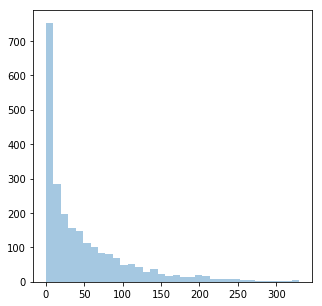

In [139]:
temp = filter_train.groupby(['Patient_id'])['SepsisLabel']\
       .sum().reset_index()

sepsis_train_pid = np.array(temp[temp['SepsisLabel'] > 0]['Patient_id'])


temp_filter = filter_train[filter_train['Patient_id']\
                                   .isin(sepsis_train_pid)]

sepsis_time = []
tot_time = []


for pid in sepsis_train_pid:
  df = temp_filter[temp_filter['Patient_id']==pid]
  sepsis_time.append(df[df['SepsisLabel']==1]['time'].iloc[0])
  tot_time.append(df[df['SepsisLabel']==1]['time'][::-1].iloc[0])

rcParams['figure.figsize'] = 5, 5

  
sns.distplot(sepsis_time, kde=False);



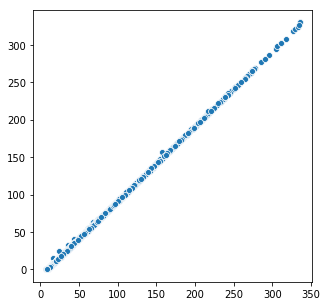

In [140]:
rcParams['figure.figsize'] = 5, 5


sns.scatterplot(tot_time, sepsis_time)

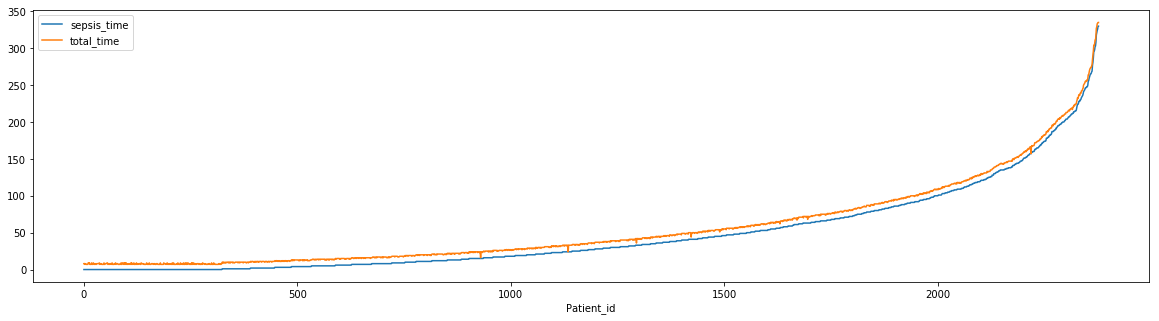

In [141]:
temp = pd.DataFrame()

temp['pid'] = sepsis_train_pid

temp['sepsis_time'] = sepsis_time

temp['tot_time'] = tot_time

temp.sort_values(by=['sepsis_time'], inplace=True)

temp['level'] = temp.reset_index().index

rcParams['figure.figsize'] = 20, 5


plt.plot(temp['level'], temp['sepsis_time'])
plt.plot(temp['level'], temp['tot_time'])
_ = plt.xlabel('Patient_id')
_ = plt.legend(['sepsis_time', 'total_time'])